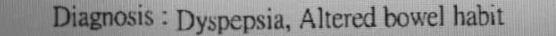

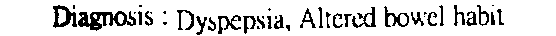

[[0 1 0]
 [1 1 1]
 [0 1 0]]


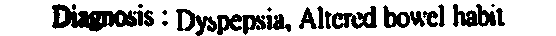

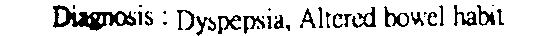

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# mport cv2.cv as cv
img = cv2.imread('./images/29.png')
GrayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(Image.fromarray(GrayImage))
ret, thresh1 = cv2.threshold(GrayImage, 110, 255, cv2.THRESH_BINARY)
display(Image.fromarray(thresh1))
# ret,thresh2=cv2.threshold(GrayImage,130,255,cv2.THRESH_BINARY_INV)
kernel = np.uint8(np.zeros((3, 3)))
kernel[1][1] = 1
kernel[0][1] = 1
kernel[1][0] = 1
kernel[1][2] = 1
kernel[2][1] = 1

# for x in range(3):
#     kernel[x, 2] = 1
#     kernel[2, x] = 1
print(kernel)
# 腐蚀图像
eroded = cv2.erode(thresh1, kernel)
display(Image.fromarray(eroded))

# display(Image.fromarray(255 - eroded))

# 膨胀图像
dilated = cv2.dilate(eroded, kernel)

display(Image.fromarray(dilated))


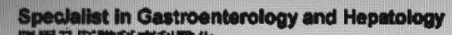

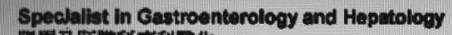

./images/3_.png
<class 'pandas.core.frame.DataFrame'>


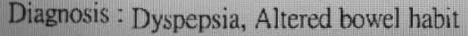

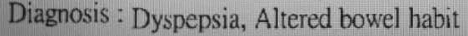

./images/29_.png
<class 'pandas.core.frame.DataFrame'>


./images/13_.png
<class 'pandas.core.frame.DataFrame'>


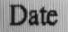

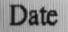

./images/25_.png
<class 'pandas.core.frame.DataFrame'>


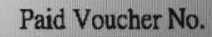

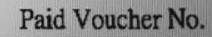

./images/24_.png
<class 'pandas.core.frame.DataFrame'>


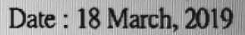

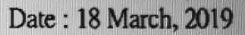

./images/12_.png
<class 'pandas.core.frame.DataFrame'>


./images/28_.png
<class 'pandas.core.frame.DataFrame'>


./images/2_.png
<class 'pandas.core.frame.DataFrame'>


./images/9_.png
<class 'pandas.core.frame.DataFrame'>


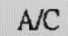

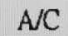

./images/23_.png
<class 'pandas.core.frame.DataFrame'>


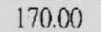

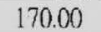

./images/19_.png
<class 'pandas.core.frame.DataFrame'>


./images/5_.png
<class 'pandas.core.frame.DataFrame'>


./images/15_.png
<class 'pandas.core.frame.DataFrame'>


./images/14_.png
<class 'pandas.core.frame.DataFrame'>


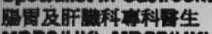

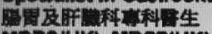

./images/4_.png
<class 'pandas.core.frame.DataFrame'>


./images/18_.png
<class 'pandas.core.frame.DataFrame'>


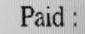

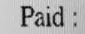

./images/22_.png
<class 'pandas.core.frame.DataFrame'>


./images/8_.png
<class 'pandas.core.frame.DataFrame'>


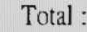

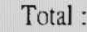

./images/21_.png
<class 'pandas.core.frame.DataFrame'>


./images/17_.png
<class 'pandas.core.frame.DataFrame'>


./images/7_.png
<class 'pandas.core.frame.DataFrame'>


./images/6_.png
<class 'pandas.core.frame.DataFrame'>


./images/16_.png
<class 'pandas.core.frame.DataFrame'>


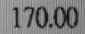

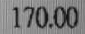

./images/20_.png
<class 'pandas.core.frame.DataFrame'>


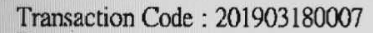

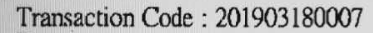

./images/11_.png
<class 'pandas.core.frame.DataFrame'>


./images/1_.png
<class 'pandas.core.frame.DataFrame'>


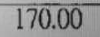

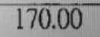

./images/27_.png
<class 'pandas.core.frame.DataFrame'>


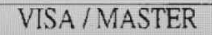

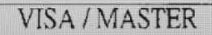

./images/26_.png
<class 'pandas.core.frame.DataFrame'>


./images/0_.png
<class 'pandas.core.frame.DataFrame'>


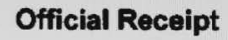

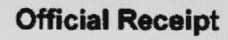

./images/10_.png
<class 'pandas.core.frame.DataFrame'>


In [50]:
from glob import glob
import pytesseract

paths = glob('./images/*_.png')

def process_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     display(img)
    
    arr = (img // 10)*10 
    counts = np.bincount(arr.flatten())
#     print(np.argmax(counts))
    
    display(Image.fromarray(img))
    
    # threshold
#     ret, thresh1 = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)
#     ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
    
    # 对比度图像增强法
#     new_arr = thresh1*2
    
    img = Image.fromarray(img)
    display(img.convert('RGB'))
    return img

for p in paths:
    image = process_img(p)
    print(p)
    text = pytesseract.image_to_data(image, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')

    print(type(text))

In [16]:
# 以 ~ | — _ 空格 开头结尾的都可以去除
# adjust调整False，然后扩展两个像素点
?Image.fromarray

Signature: Image.fromarray(obj, mode=None)
Docstring:
Creates an image memory from an object exporting the array interface
(using the buffer protocol).

If **obj** is not contiguous, then the tobytes method is called
and :py:func:`~PIL.Image.frombuffer` is used.

If you have an image in NumPy::

  from PIL import Image
  import numpy as np
  im = Image.open('hopper.jpg')
  a = np.asarray(im)

Then this can be used to convert it to a Pillow image::

  im = Image.fromarray(a)

:param obj: Object with array interface
:param mode: Mode to use (will be determined from type if None)
  See: :ref:`concept-modes`.
:returns: An image object.

.. versionadded:: 1.1.6
File:      /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/PIL/Image.py
Type:      function


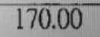

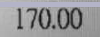

In [116]:
# left 不为-1的拼接，特殊符号去空格，单词之间空格连接
# 直线检测

import cv2 as cv
import numpy as np


def line_detect_possible(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, 50, 100, apertureSize = 3)
#     display(Image.fromarray(edges))
    # minLineLength - 线段的最小长度. Line segments shorter than this are rejected.
    # maxLineGap - 使程序识别线段为一条线的线段之间最大的空隙
    lines = cv.HoughLinesP(edges, 1, np.pi/180, 50, 100, minLineLength = 50, maxLineGap = 1)
    if lines is None:
        return 
    
#     display(Image.fromarray(image))
    h, w, _ = image.shape
    for line in lines:
        x1, y1, x2, y2 = line[0] 
        # 画蓝色
        #cv.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv.line(image, (0, y1), (w, y2), (180, 180, 200), 2)
    
    img = Image.fromarray(image)
    display(img)
    return img

src = cv.imread("./images/17_.png")
display(Image.fromarray(src))
line_detect_possible(src)

src = cv.imread("./images/27_.png")
display(Image.fromarray(src))
line_detect_possible(src)

src = cv.imread("./images/1_.png")
display(Image.fromarray(src))
line_detect_possible(src)

# 只处理水平干扰线（需要判断是否为水平）
# 占长度的60%以上 才算干扰线
# 高斯填充

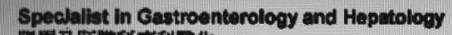

   conf              text
4    78        Speclalist
5    94                In
6    96  Gastroenterology
7    96               and
8    95        Hepatology


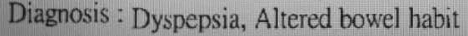

   conf        text
4    92   Diagnosis
5    92           :
6    96  Dyspepsia,
7    96     Altered
8    96       bowel
9    96       habit


   conf    text
4    96  Doctor


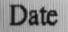

   conf  text
4    96  Date


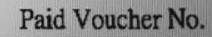

   conf     text
4    96     Paid
5    96  Voucher
6    96      No.


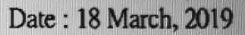

   conf    text
4    93    Date
5    91       :
6    96      18
7    96  March,
8    96    2019


   conf  text
4    96    18
5    96  Mar,
6    96  2019


./images/28_.png
   conf  text
4    96    18
5    96  Mar,
6    96  2019


   conf     text
4    96        1
5    44   Pedder
6    94      St,
7    90  Central


   conf              text
4    38  FHIKAM(Medicine)
5    92        MSc(Health
6    96               and
7    93          Hospital
8    47        Mgt)(Birm)


./images/9_.png
   conf             text
4    55  FHKAM(Medicins)
5    92       MSc(Health
6    96              and
7    93         Hospital
8    91       Mgt)(Birm)


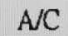

   conf text
4    86  A/C


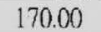

   conf   text
4    96  170.0


   conf  text
4    84  Hong
5    95  Kong


   conf    text
4    96  Amount


   conf     text
4    95  Patient
5    96     Code


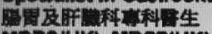

   conf text
5    43    2
7    46   4:


   conf        text
4    49  MEDICATION


./images/18_.png
   conf        text
4    72  MEDICATION


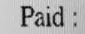

   conf  text
4    93  Paid
5    91     :


   conf  text
4    93   Fax
5    93     :
6    96  2530
7    88  0839


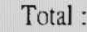

   conf   text
4    93  Total
5    93      :


   conf   text
4    96  170.0


./images/17_.png
   conf   text
4    78  170.0


   conf        text
4    39    MBBS(HK)
5    91    MRCP(UK)
6    91  FRCP(Edin)
7    90       FHKCP


   conf  text
4    90   Tel
5    90     :
6    96  2530
7    88  0833


   conf   text
4    63  Items


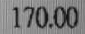

   conf   text
4    94  170.0


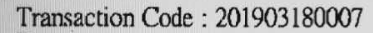

   conf          text
4    95   Transaction
5    93          Code
6    93             :
7    96  201903180007


   conf      text
4    92      Room
5    96      529,
6    91   Central
7    20  Building


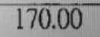

   conf    text
4    60  170,00


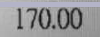

./images/27_.png
   conf   text
4    90  170.0


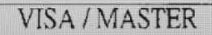

   conf     text
4    47     VISA
5    89  /MASTER


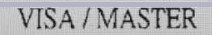

./images/26_.png
   conf    text
4    91    VISA
5    91       /
6    96  MASTER


   conf text
4     5  SE]


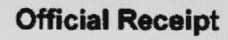

   conf      text
4    96  Official
5    96   Receipt


In [117]:
for p in paths:
    src = cv.imread(p)
    
    display(Image.fromarray(src))
    df1 = pytesseract.image_to_data(src, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
    print(df1[df1.conf>0][['conf', 'text']])
    
    image = line_detect_possible(src)
    
    if image is not None:
        print(p)

        
        df = pytesseract.image_to_data(image, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
        print(df[df.conf>0][['conf', 'text']])

In [112]:
for p in paths:
    print(p)
    src = cv.imread(p)
    df1 = pytesseract.image_to_data(src, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
    print(df1[df1.conf>0][['conf', 'text']])

./images/3_.png
   conf              text
4    78        Speclalist
5    94                In
6    96  Gastroenterology
7    96               and
8    95        Hepatology
./images/29_.png
   conf        text
4    92   Diagnosis
5    92           :
6    96  Dyspepsia,
7    96     Altered
8    96       bowel
9    96       habit
./images/13_.png
   conf    text
4    96  Doctor
./images/25_.png
   conf  text
4    96  Date
./images/24_.png
   conf     text
4    96     Paid
5    96  Voucher
6    96      No.
./images/12_.png
   conf    text
4    93    Date
5    91       :
6    96      18
7    96  March,
8    96    2019
./images/28_.png
   conf  text
4    96    18
5    96  Mar,
6    96  2019
./images/2_.png
   conf     text
4    96        1
5    44   Pedder
6    94      St,
7    90  Central
./images/9_.png
   conf              text
4    38  FHIKAM(Medicine)
5    92        MSc(Health
6    96               and
7    93          Hospital
8    47        Mgt)(Birm)
./images/23_.png
   conf text
4  